# Optical RL-Gym

In [1]:
import sys,os,pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from Physical_Params import *

path ='C:/Users/D-GAMING-MACHINE/Documents/ELG5381/BranchingDQN/'
sys.path.append(path)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


# Import Agent

In [2]:
# silencing tensorflow warnings
import tensorflow as tf
import gymnasium as gym
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)
tf.ConfigProto(device_count = {'GPU': 1})
tf.__version__

'1.15.0'

In [3]:
import stable_baselines3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from sb3_contrib import RecurrentPPO as RPPO
from stable_baselines3.common.monitor import Monitor
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common import results_plotter
stable_baselines3.__version__

'2.0.0'

In [4]:
import gymnasium as gym
import tensorflow as  tf
import torch  as th 
print(th.cuda.is_available())
#print(stable_baselines3.common.utils.get_device())
from optical_rl_gym.utils import Path, evaluate_heuristic, random_policy
from optical_rl_gym.envs.qos_constrained_ra import MatrixObservationWithPaths
from optical_rl_gym.envs.rwa_env import PathOnlyFirstFitAction

True


In [5]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                 # Mean training reward over the last 50 episodes
                mean_reward = np.mean(y[-50:])
                if self.verbose > 0:
                    print("Num timesteps: {} - ".format(self.num_timesteps), end="")
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))
                  # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model to {}".format(self.save_path))
                        self.model.save(self.save_path)
                if self.verbose > 0:
                    clear_output(wait=True)

        return True

In [6]:
topology_name = 'nsfnet_chen_eon'
k_paths = 5
episode_num = 400
episode_length = 5000
with open(f'topologies/nsfnet_chen_5-paths_6-modulations.h5', 'rb') as f:
    topology = pickle.load(f)
    

node_num = topology.number_of_nodes()
req_tens = 1/node_num/(node_num-1)*np.ones((node_num,node_num)) #uniform node request probability tensor
node_request_probabilities = req_tens.dot(np.ones(node_num))
env_args = dict(seed=10, allow_rejection=True,
                load=450, episode_length=episode_length, num_spectrum_resources=16,
                topology = topology,
                node_request_probabilities = node_request_probabilities,
                    )
topology.edges()

EdgeView([('1', '2'), ('1', '3'), ('1', '8'), ('2', '3'), ('2', '4'), ('3', '6'), ('4', '5'), ('4', '11'), ('5', '6'), ('5', '7'), ('6', '10'), ('6', '14'), ('7', '8'), ('7', '10'), ('8', '9'), ('9', '10'), ('9', '12'), ('9', '13'), ('11', '12'), ('11', '13'), ('12', '14'), ('13', '14')])

In [7]:
# Create log dir
log_dir = "./tmp/rwa-rppo/"
os.makedirs(log_dir, exist_ok=True)
callback = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir)

env = gym.make('RWA-v0', **env_args)

# uses a matrix observation with paths
env = MatrixObservationWithPaths(env)

# logs will be saved in log_dir/monitor.csv
# in our case, on top of the usual monitored metrics, we also monitor service blocking rate
env = Monitor(env, log_dir + 'training', info_keywords=('episode_service_blocking_rate','episode_service_accepted'))

policy_args = dict(net_arch=3*[256]) # the neural network has 2 layers with 128 neurons each

agent = RPPO(MlpLstmPolicy, env, verbose=0, tensorboard_log="./tb/RPPO-RWA-v0/", policy_kwargs=policy_args, gamma=.95, learning_rate=1.57e-5,batch_size=256)

In [8]:
agent.learn(total_timesteps=episode_length*episode_num, callback=callback)

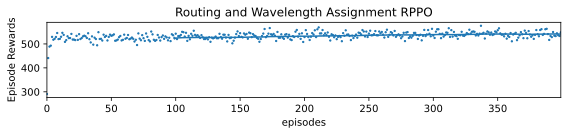

In [9]:
results_plotter.plot_results([log_dir], episode_num*episode_length, results_plotter.X_EPISODES_SERVICES, "Routing and Wavelength Assignment RPPO")